# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» (название вымышленное) внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Задачи:**

- Провести исследовательский анализ набора фотографий и подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество. Значение метрики MAE не должно быть выше 8.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from PIL import Image
import os
import random

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
labels.shape

(7591, 2)

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

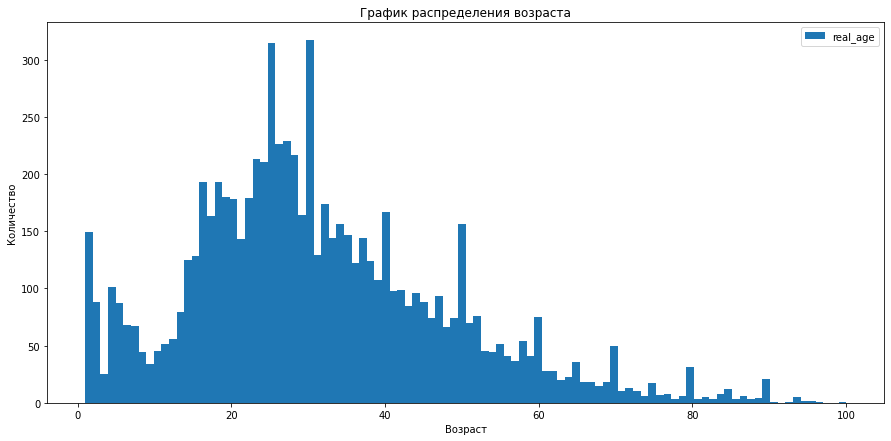

In [ ]:
labels.plot(kind='hist', figsize=(15,7), bins=100)
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера 2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>



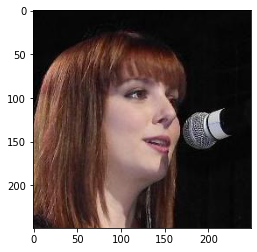

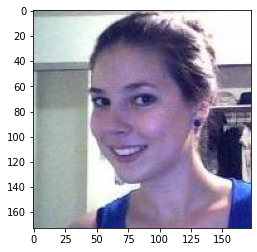

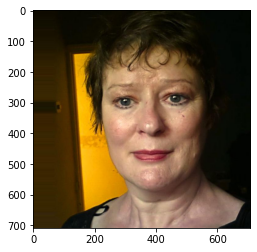

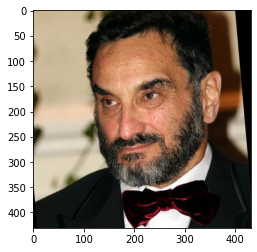

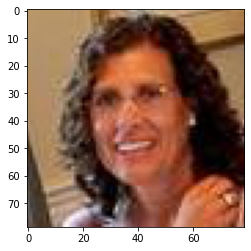

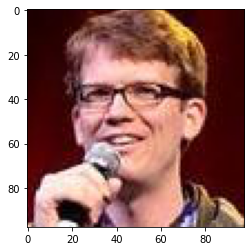

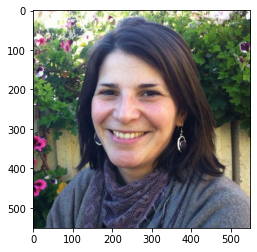

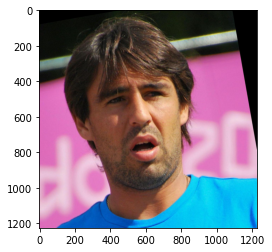

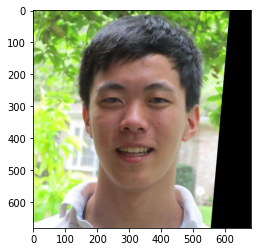

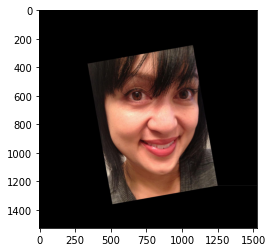

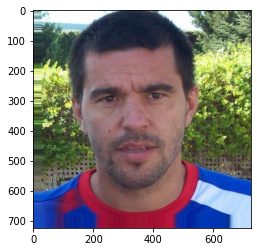

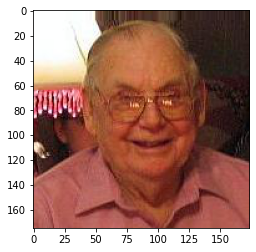

In [ ]:
images = os.listdir('/datasets/faces/final_files/')
for i in random.sample(images, k=12):
    image = Image.open('/datasets/faces/final_files/' + i)
    plt.imshow(np.array(image))
    plt.show()

Выборка содержит 7591 изображение с данными по возрасту человека на фото. Диапазон возрастов - от 1 года до 100 лет. Людей от 20 до 30 лет в выборке больше всего. Средний возраст — 31, медианный — 29. Среди фотографий есть как цветные, так и черно-белые. Также фотографии имеют разное качество.
В целом общая ориненатция фотографий выстроена правильно, однако, можно заметить, что некоторые фотографии повернуты, но скорее всего это не будет мешать обучению, поскольку необходимые признаки остаются на месте.

## Обучение модели

```python

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-04-17 20:26:01.814066: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-17 20:26:02.124451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 50s - loss: 227.1062 - mae: 10.7973 - val_loss: 705.2946 - val_mae: 21.5365
Epoch 2/10
356/356 - 38s - loss: 85.8398 - mae: 7.0162 - val_loss: 198.3195 - val_mae: 11.3412
Epoch 3/10
356/356 - 38s - loss: 57.2598 - mae: 5.7947 - val_loss: 83.2832 - val_mae: 6.9255
Epoch 4/10
356/356 - 38s - loss: 43.3183 - mae: 5.0590 - val_loss: 92.1138 - val_mae: 7.1349
Epoch 5/10
356/356 - 38s - loss: 32.8752 - mae: 4.4176 - val_loss: 85.8710 - val_mae: 7.2186
Epoch 6/10
356/356 - 38s - loss: 22.8385 - mae: 3.6757 - val_loss: 71.4764 - val_mae: 6.6193
Epoch 7/10
356/356 - 40s - loss: 20.9079 - mae: 3.3956 - val_loss: 69.2511 - val_mae: 6.2079
Epoch 8/10
356/356 - 42s - loss: 16.6203 - mae: 3.0968 - val_loss: 66.8253 - val_mae: 6.2823
Epoch 9/10
356/356 - 44s - loss: 14.6094 - mae: 2.9276 - val_loss: 80.3363 - val_mae: 6.6822
Epoch 10/10
356/356 - 45s - loss: 13.8180 - mae: 2.8407 - val_loss: 64.6909 - val_mae: 6.0322
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 64.6909 - mae: 6.0322
Test MAE: 6.0322

```

## Анализ обученной модели

Модель построена на основе ResNet50, и в качестве метрики использовалась MAE. Модель показала на тестовой выборке неплохой результат - 6.03, это значит, что она сможет определять возраст покупатлей с ошибкой примерно в 6 лет и ее можно внедрять в магазины. Однако учитывая, что погрешность 6 лет может быть значимой для определения возраста при покупке алкоголя, потребуется более внимательная проверка возраста с участием человека из-за высокой цены ошибки для бизнеса.
